In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
diagnosis = pd.read_csv('/content/drive/My Drive/patient_diagnosis-new.csv')
diagnosis = diagnosis.to_dict()
ids=list(diagnosis['ID'].values())
#print(len(ids))
symp=list(diagnosis['Symptom'].values())
#print(len(symp))

folder = '/content/drive/My Drive/ICBHI_final_database/**'


dataset=[]
for filename in glob.iglob(folder):
  
  if (filename[-4:]=='.wav'):
    identity = filename.split('/')[-1][:3]
    #print(identity)
    if int(identity) in ids:
      #print(identity)
      index=ids.index(int(identity))
      label = symp[index]
      duration = librosa.get_duration(filename=filename)
      #print(identity, label, duration)
      if duration>= 3:
        slice_size = 3
        iterations = int((duration-slice_size)/(slice_size-1))
        iterations += 1
#                 initial_offset = (duration % slice_size)/2
        initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
        for i in range(iterations):
          offset = initial_offset + i*(slice_size-1)
          dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
          

dataset = pd.DataFrame(dataset)
#dataset = shuffle(dataset, random_state=42)
dataset.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1640 non-null   object 
 1   label     1640 non-null   object 
 2   offset    1640 non-null   float64
dtypes: float64(1), object(2)
memory usage: 38.6+ KB


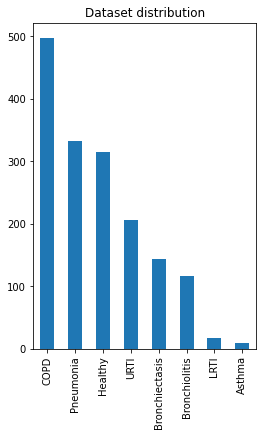

In [ ]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()  

In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1312
Test: 328


/content/drive/My Drive/ICBHI_final_database/101_1b1_Al_sc_Meditron.wav
/content/drive/My Drive/ICBHI_final_database/102_1b1_Ar_sc_Meditron.wav
/content/drive/My Drive/ICBHI_final_database/103_2b2_Ar_mc_LittC2SE.wav
/content/drive/My Drive/ICBHI_final_database/104_1b1_Al_sc_Litt3200.wav
/content/drive/My Drive/ICBHI_final_database/108_1b1_Al_sc_Meditron.wav
/content/drive/My Drive/ICBHI_final_database/111_1b2_Tc_sc_Meditron.wav
/content/drive/My Drive/ICBHI_final_database/122_2b1_Al_mc_LittC2SE.wav
/content/drive/My Drive/ICBHI_final_database/149_1b1_Al_sc_Meditron.wav


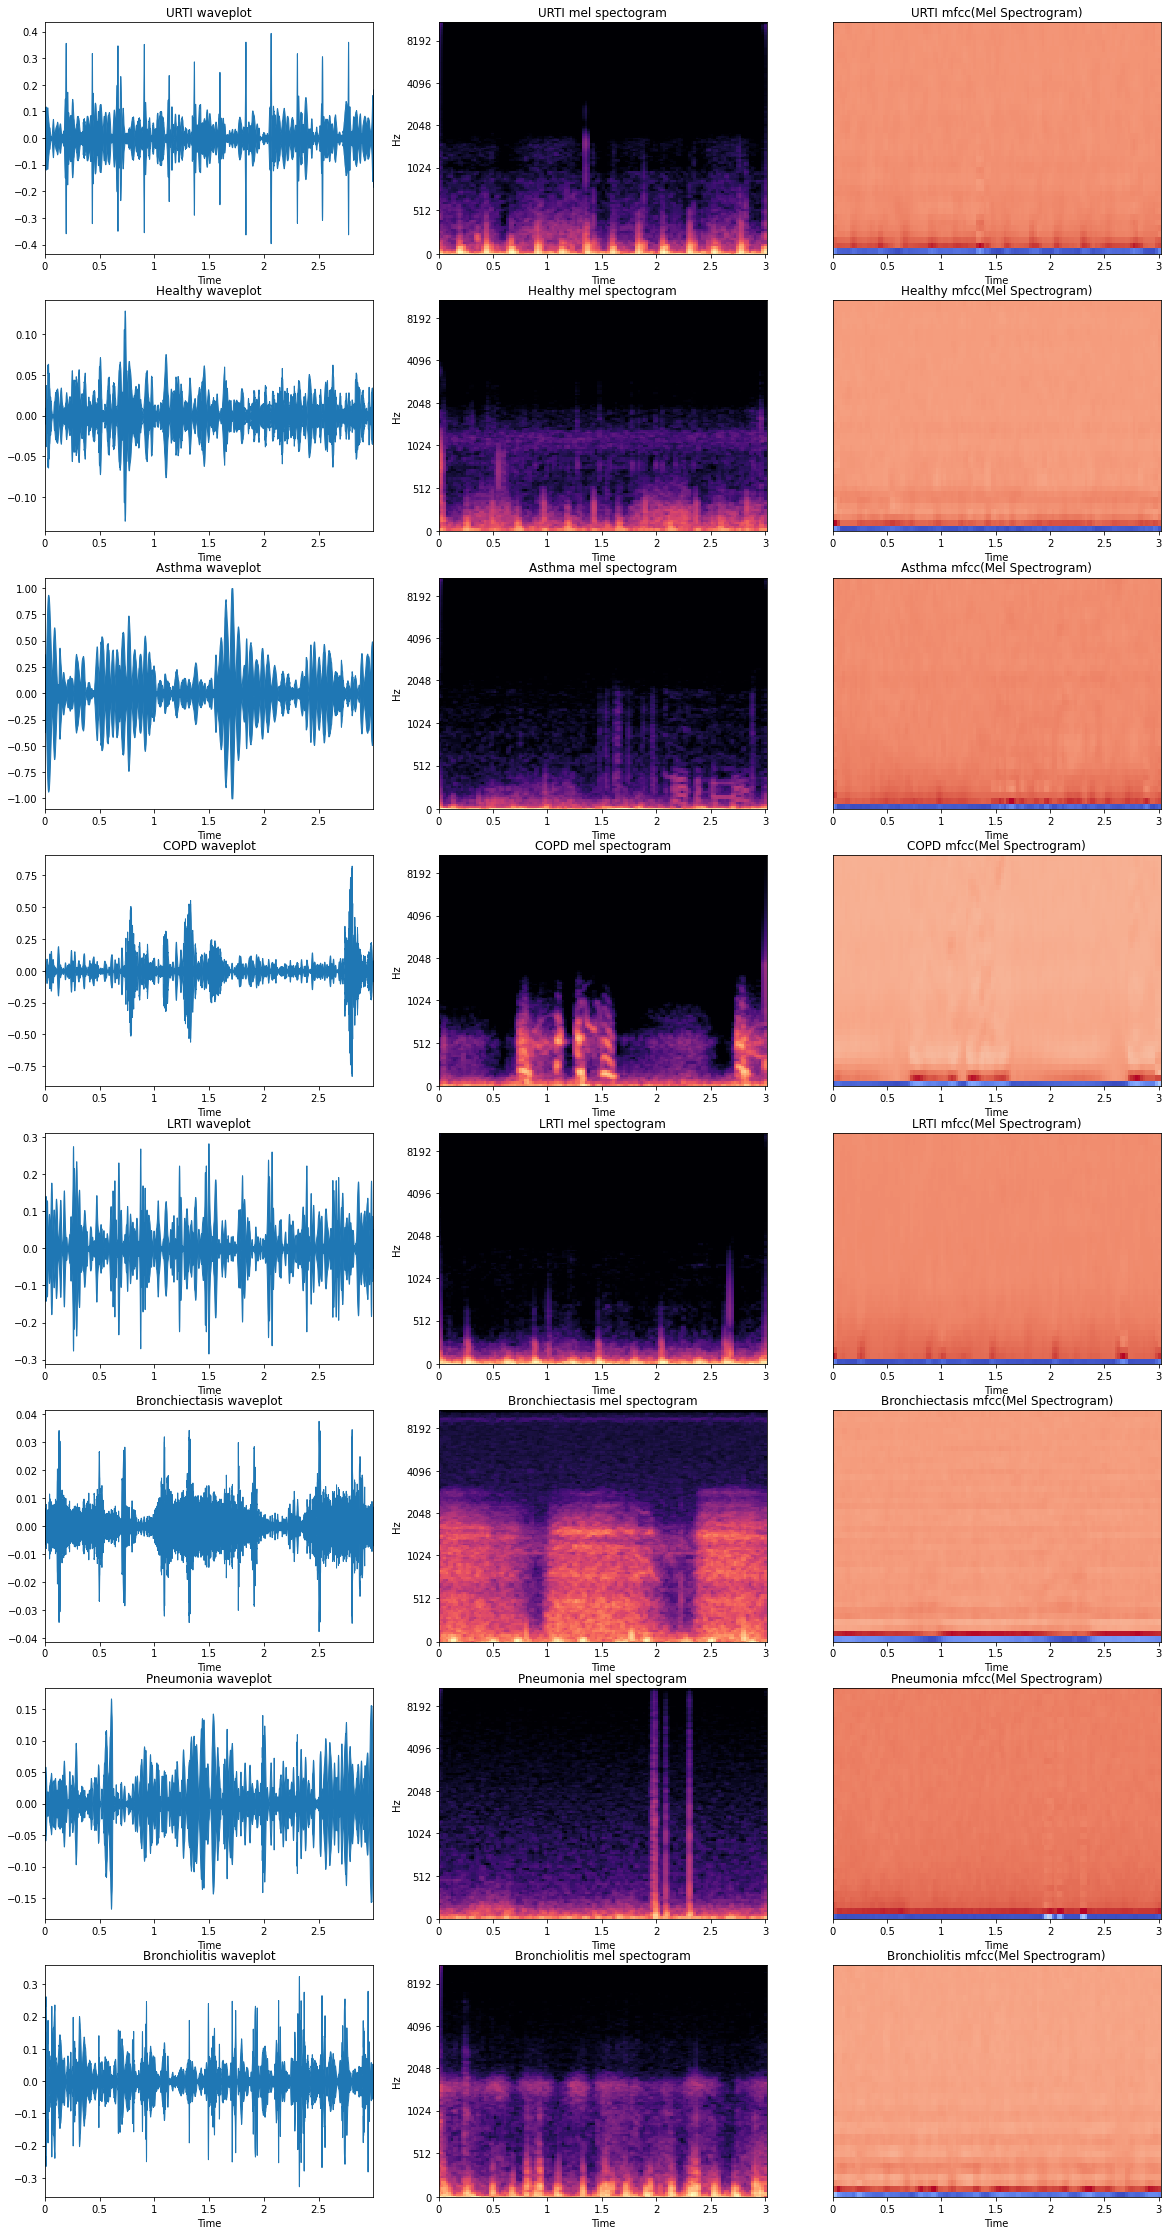

In [ ]:
plt.figure(figsize=(20,40))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[1], duration=3)
    print(dataset[dataset.label==label].filename.iloc[1])
    
    # Wave plot
    idx+=1
    plt.subplot(8, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(8, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(8, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

In [ ]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [ ]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = (np.asarray(x_test))
x_train = (np.asarray(x_train))

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 328/328 [01:00<00:00,  5.39it/s]


X train: (1312, 40, 130)
X test: (328, 40, 130)


In [ ]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1312, 40, 130, 1)
Y train: (1312, 8)
X test: (328, 40, 130, 1)
Y test: (328, 8)


In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 31, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 30, 64)         8

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/300
11/11 [==============================] - 6s 411ms/step - loss: 11.0782 - accuracy: 0.1918 - val_loss: 2.0714 - val_accuracy: 0.3750
Epoch 2/300
11/11 [==============================] - 4s 404ms/step - loss: 4.4367 - accuracy: 0.2495 - val_loss: 1.8323 - val_accuracy: 0.3720
Epoch 3/300
11/11 [==============================] - 4s 384ms/step - loss: 2.5363 - accuracy: 0.2677 - val_loss: 1.7906 - val_accuracy: 0.3689
Epoch 4/300
11/11 [==============================] - 4s 386ms/step - loss: 1.9828 - accuracy: 0.3034 - val_loss: 1.7276 - val_accuracy: 0.3872
Epoch 5/300
11/11 [==============================] - 4s 388ms/step - loss: 1.7768 - accuracy: 0.3734 - val_loss: 1.6935 - val_accuracy: 0.3750
Epoch 6/300
11/11 [==============================] - 4s 386ms/step - loss: 1.5865 - accuracy: 0.4125 - val_loss: 1.6509 - val_accuracy: 0.3780
Epoch 7/300
11/11 [==============================] - 4s 399ms/step - loss: 1.5510 - accuracy: 0.4306 - val_loss: 1.6075 - val_accuracy: 0.384

Text(0.5, 1.0, 'Accuracy Curves')

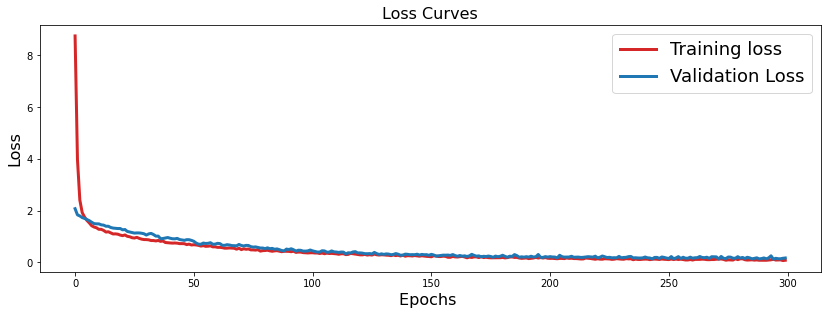

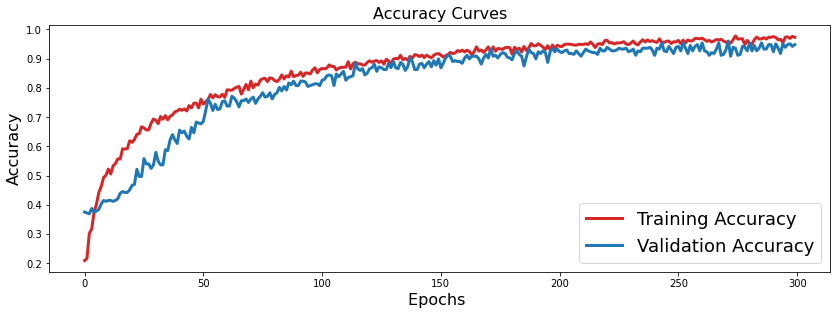

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

11/11 [==============================] - 0s 33ms/step - loss: 0.1647 - accuracy: 0.9482
Test loss: 0.16467227041721344
Test accuracy: 0.9481707215309143


In [ ]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

11/11 [==============================] - 0s 31ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00         3
Bronchiectasis       1.00      1.00      1.00        30
 Bronchiolitis       0.95      1.00      0.98        21
          COPD       1.00      0.98      0.99       118
       Healthy       0.95      0.86      0.90        65
          LRTI       0.50      1.00      0.67         2
     Pneumonia       1.00      0.93      0.96        59
          URTI       0.72      0.93      0.81        30

      accuracy                           0.95       328
     macro avg       0.89      0.96      0.91       328
  weighted avg       0.96      0.95      0.95       328



In [ ]:
model_name = "heartbeat_classifier-new.h5"
model.save('/content/drive/My Drive/'+model_name)

In [ ]:
# # load and evaluate a saved model
from keras.models import load_model
 
# # load model
model = load_model("/content/drive/My Drive/heartbeat_classifier-new.h5")

# # File to be classified
classify_file = "/content/drive/My Drive/ICBHI_final_database/140_2b3_Ll_mc_LittC2SE.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 [==============================] - 0s 89ms/step
[[5.5575966e-09 1.0580204e-04 5.3018877e-05 6.2012166e-04 5.0448095e-03
  2.8557099e-06 9.9415624e-01 1.7114466e-05]]


In [ ]:
pred_class = model.predict(x_test)
index = np.argmax(pred_class, axis=1)
#pred_class = model.predict(x_test).astype("int32")
#if pred_class[0]:
#     print("Normal heartbeat")
#     print("confidence:",pred[0][1])
#else:
#     print("Abnormal heartbeat")
#     print("confidence:",pred[0][0])
print(index)

[6]
